## Importing the model

##### Importing packages

In [284]:
import config
import models
import tasks
import networks
import plots
import argparse
import json
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import numpy as np

##### Specifying the model

In [308]:
dim_recurrent = 100
simple_input = True
simple_output = True
reg_norm = 0
reg_lam = 0
noise = 0.1
hold_zero=False
init_random = "XY"
parameter_updates = 0 # 0 = best network overall
redo_preanalysis = True # None = redo only if necessary

In [309]:
ORI_RES = 5
ORI_SET = np.arange(0, 180, ORI_RES)
ORI_SET_SIZE = ORI_SET.shape[0]

##### Loading the model

In [310]:
task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT()
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent)
delay0_set = torch.arange(10, 51)
delay1_set = torch.arange(10, 51)
delay2_set = torch.arange(10, 51)

directory = f"t{task.name}_m{model.name}_dr{dim_recurrent}"
if hold_zero:
    directory += "_hz"
if reg_norm > 0:
    directory += f"_l{reg_norm}_la{reg_lam}"
if not simple_input:
    directory += "_nsi"
if not simple_output:
    directory += "_nso"
directory += f"_n{noise}_r{init_random}"
directory = "data/" + directory

if parameter_updates > 0:
    model_filename = f"model_parameterupdate{parameter_updates}.pth"
else:
    model_filename = f"model_best.pth"

In [311]:
if redo_preanalysis is None:
    index = model_filename.split(".")[0]
    redo_preanalysis = not os.path.exists(f"{directory}/{index}_megabatch_tuningdata.pt")
    
if redo_preanalysis:
    ######################## PREANALYSIS CODE
    
    hold_orientation_for, hold_cue_for = 50, 50
    #delay0, delay1, delay2 = delay0_set[-1].item(), delay1_set[-1].item(), delay2_set[-1].item()
    #delay0, delay1, delay2 = torch.median(delay0_set).item(), torch.median(delay1_set).item(), torch.median(delay2_set).item()
    delay0, delay1, delay2 = 50, 50, 50
    total_time = hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2

    orientation_neurons = 32
    task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT(orientation_neurons, hold_orientation_for, hold_cue_for, delay0_set, delay1_set, delay2_set,
                                            simple_input=simple_input, simple_output=simple_output)
    model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
    
    print("Carrying out pre-analysis...")

    state_dict = torch.load(f"{directory}/{model_filename}")["model_state_dict"]
    model.load_state_dict(state_dict)

    ####################################
    print("Generating megabatch...")

    def generate_megabatch(task, delay0, delay1, delay2):
        batch = []
        batch_labels = []
        output_masks = []
        for orientation1 in ORI_SET:
            for orientation2 in ORI_SET:
                to_batch, to_batch_labels, to_mask = task._make_trial(orientation1, orientation2, delay0, delay1, delay2)
                batch.append(to_batch.unsqueeze(0))
                batch_labels.append(to_batch_labels.unsqueeze(0))
                output_masks.append(to_mask.unsqueeze(0))
        return torch.cat(batch).to(config.device), torch.cat(batch_labels).to(config.device), torch.cat(
            output_masks).to(config.device)
    batch = generate_megabatch(task, delay0, delay1, delay2)
    print("Running the model...")
    output = model(batch[0])

    ####################################
    print("Calculating data_all...")

    data_all = torch.zeros((total_time, dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
    for orientation1 in range(ORI_SET_SIZE):
        for orientation2 in range(ORI_SET_SIZE):
            o = output[1][orientation1 * ORI_SET_SIZE + orientation2]
            data_all[:, :, orientation1, orientation2] = o

    ####################################
    print("Calculating tuning indices...")
    
    tuning_indices = []
    for timestep in range(total_time):
        sor = []
        for i in range(dim_recurrent):
            data_in = data_all[timestep][i]
            var1 = torch.var(torch.sum(data_in, axis=1))+0.01
            var2 = torch.var(torch.sum(data_in, axis=0))+0.01
            var = (var1/var2).item()
            #if var>10:
            sor.append({"id": i, "var": var, "pref": (1 if var1>var2 else 2)})
           # print(f"UNIT {i}: {var1/var2+var2/var1}")
        sor = sorted(sor, reverse=True, key=lambda x: x["var"])
        sor_i = [x["id"] for x in sor]
        tuning_indices.append(sor_i)
    tuning_indices = torch.tensor(tuning_indices, dtype=int)

    ####################################
    print("Saving...")

    result = {}
    #result["sor_i"] = sor_i
    #result["sor"] = sor
    result["hold_orientation_for"] = hold_orientation_for
    result["hold_cue_for"] = hold_cue_for
    result["delay0"] = delay0
    result["delay1"] = delay1
    result["delay2"] = delay2

    #retrievedTensor = tf.tensor(saved.data, saved.shape)
    
    index = model_filename.split(".")[0]
    torch.save(data_all, f"{directory}/{index}_megabatch_tuningdata.pt")
    torch.save(tuning_indices, f"{directory}/{index}_megabatch_tuningindices.pt")
    torch.save(output, f"{directory}/{index}_megabatch_output.pt")
    torch.save(batch[0], f"{directory}/{index}_megabatch_input.pt")
    torch.save(batch[1], f"{directory}/{index}_megabatch_target.pt")
    torch.save(batch[2], f"{directory}/{index}_megabatch_mask.pt")
    with open(f"{directory}/{index}_info.json", 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False, indent=4)
    print("Done...")

Carrying out pre-analysis...
Generating megabatch...
Running the model...
Calculating data_all...
Calculating tuning indices...
Saving...
Done...


In [312]:
index = model_filename.split(".")[0]
with open(f"{directory}/{index}_info.json", 'r', encoding='utf-8') as f:
    j = json.load(f)

hold_orientation_for = j["hold_orientation_for"]
hold_cue_for = j["hold_cue_for"]
delay0 = j["delay0"]
delay1 = j["delay1"]
delay2 = j["delay2"]
total_time = hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2

orientation_neurons = 32
task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT(orientation_neurons, hold_orientation_for, hold_cue_for, delay0_set, delay1_set, delay2_set,
                                            simple_input=simple_input, simple_output=simple_output)
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")

state_dict = torch.load(f"{directory}/{model_filename}")["model_state_dict"]
model.load_state_dict(state_dict)

megabatch_tuningdata = torch.load(f"{directory}/{index}_megabatch_tuningdata.pt")
megabatch_tuningindices = torch.load(f"{directory}/{index}_megabatch_tuningindices.pt")
megabatch_output = torch.load(f"{directory}/{index}_megabatch_output.pt")
megabatch_input = torch.load(f"{directory}/{index}_megabatch_input.pt")
megabatch_target = torch.load(f"{directory}/{index}_megabatch_target.pt")
megabatch_mask = torch.load(f"{directory}/{index}_megabatch_mask.pt")

##### Useful functions for plotting

In [313]:
def annotate_task_on_plt(plt):
    # add ticks
    plt.xticks([0, 
                delay0,
                delay0+hold_orientation_for, 
                delay0+hold_orientation_for+delay1, 
                delay0+hold_orientation_for*2+delay1,
                delay0+hold_orientation_for*2+delay1+delay2, 
                delay0+hold_orientation_for*2+delay1+delay2+hold_cue_for])
    # add patches to visualize inputs
    plt.axvspan(delay0, delay0+hold_orientation_for, facecolor="r", alpha=0.1)
    plt.axvspan(delay0+hold_orientation_for+delay1, delay0+hold_orientation_for*2+delay1, facecolor="b", alpha=0.1)
    plt.axvspan(delay0+hold_orientation_for*2+delay1+delay2, 
                delay0+hold_orientation_for*2+delay1+delay2+hold_cue_for, facecolor="k", alpha=0.1)
    # add patches to legend
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(mpatches.Patch(color='r', alpha=0.3, label='O1 presented'))
    handles.append(mpatches.Patch(color='b', alpha=0.3, label='O2 presented'))
    handles.append(mpatches.Patch(color='k', alpha=0.3, label='cue presented')) 
    plt.legend(handles=handles)
def show_images_side_by_side(images):
    plt.close('all')
    n = len(images)
    sqt = math.ceil(n ** 0.5)
    if n==1: nrows, ncols=1, 1
    if n==2: nrows, ncols=1, 2
    if n==3: nrows, ncols=1, 3
    if n>3: nrows, ncols=sqt, sqt
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
    if nrows == 1:
        if ncols == 1: ax = np.array([[ax]])
        else: ax = np.array([ax])
    else:
        if ncols == 1: ax = np.array([[ax[0]], [ax[1]]])
    for a in ax.ravel():
        a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        a.imshow(images[i])
    plt.tight_layout()
    #st = fig.suptitle(f"Tuning to orientations {timestep_description}", fontsize=20)
    #st.set_y(0.95)
    #fig.supxlabel('Orientation (0 to 180 deg), orientation1 (red) and orientation2 (black)', fontsize=14)
    #fig.supylabel('Average activation (0 to 1), with standard deviation', fontsize=14)
    #fig.subplots_adjust(top=0.95, left=0.04, bottom=0.04)
    #fig.show()
    #plt.close('all')
def plt_to_image(fig):
    fig.canvas.draw()
    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return data

## Neuron tunings over time

In [314]:
select_top = 40
R1_indices = megabatch_tuningindices[:, :select_top].clone()
R2_indices = megabatch_tuningindices[:, -select_top:].clone()
DT_indices = megabatch_tuningindices[:, select_top:-select_top].clone()
DT_R1_indices = megabatch_tuningindices[:, select_top:-select_top].clone()
DT_R2_indices = megabatch_tuningindices[:, select_top:-select_top].clone()

Sort ring units by preferred orientation:

In [315]:
for t in range(R1_indices.shape[0]):
    R1_i = R1_indices[t].clone()
    R2_i = R2_indices[t].clone()
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][R2_i], dim=1), dim=1)*ORI_RES
    R1_indices[t] = R1_indices[t].clone()[torch.argsort(R1_pref)]
    R2_indices[t] = R2_indices[t].clone()[torch.argsort(R2_pref)]
    
    DT_i = DT_indices[t].clone()
    DT_R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][DT_i], dim=2), dim=1)*ORI_RES
    DT_R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][DT_i], dim=1), dim=1)*ORI_RES
    DT_R1_indices[t] = DT_R1_indices[t].clone()[torch.argsort(DT_R1_pref)]
    DT_R2_indices[t] = DT_R2_indices[t].clone()[torch.argsort(DT_R2_pref)]
    
R1_i = R1_indices[-1]
R2_i = R2_indices[-1]
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R2_i], dim=1), dim=1)*ORI_RES

### Plot overlap over time with last timestep

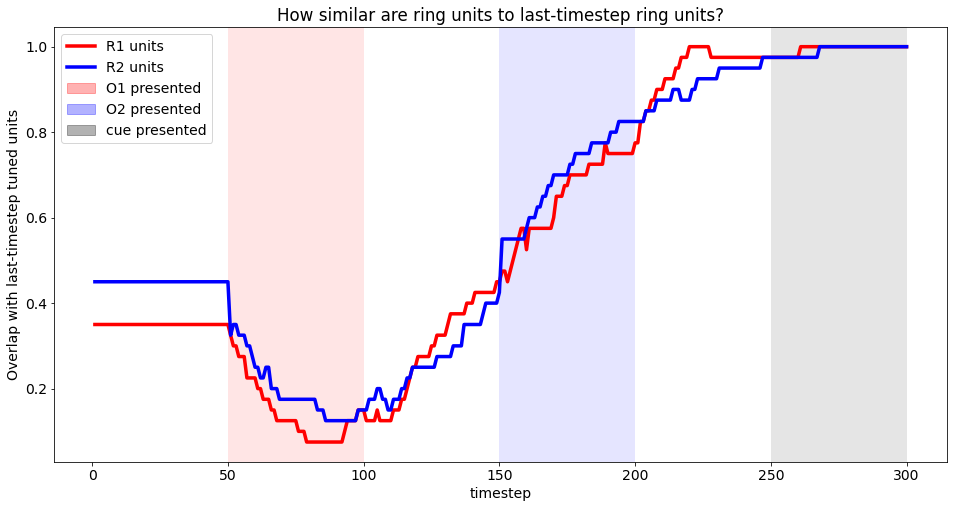

In [316]:
intersection_size_r1 = [np.intersect1d(R1_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_r2 = [np.intersect1d(R2_indices[-1], R2_indices[t]).shape[0]/R2_indices[-1].shape[0] for t in range(total_time)]
time = range(1, total_time+1)

font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.figure(figsize=(16, 8))
plt.plot(time, intersection_size_r1, "r-", linewidth=3.5, markersize=10, label="R1 units")
plt.plot(time, intersection_size_r2, "b-", linewidth=3.5, markersize=10, label="R2 units")
plt.xlabel('timestep')
plt.ylabel('Overlap with last-timestep tuned units')
plt.title(f'How similar are ring units to last-timestep ring units?')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

## R1 and R2 connectivity

In [317]:
def get_connplot_graph(timestep):
    R1_i = R1_indices[timestep]
    R2_i = R2_indices[timestep]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
    W = model.fc_h2ah.weight
    sm = 8 # size of smoothing
    distances_weights = {}
    for i in range(len(R1_i)):
        for j in range(len(R1_i)):
            if j == i: continue
            diff = (R1_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            diff = (diff // sm) * sm
            if diff not in distances_weights: distances_weights[diff] = []
            w_ij = W[R1_i[j], R1_i[i]] # weight from i to j 
            distances_weights[diff].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(R2_i)):
        for j in range(len(R2_i)):
            if j == i: continue
            diff = (R2_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            diff = (diff // sm) * sm
            if diff not in distances_weights: distances_weights[diff] = []
            w_ij = W[R2_i[j], R2_i[i]] # weight from i to j 
            distances_weights[diff].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

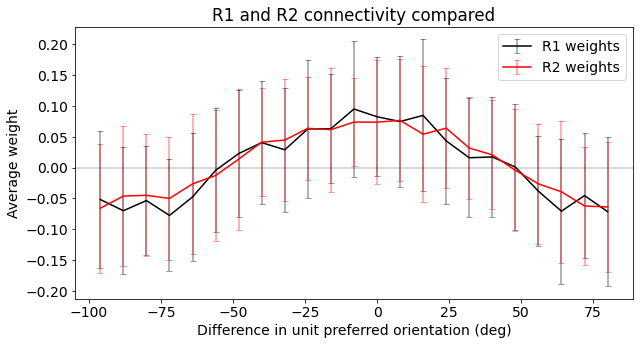

In [318]:
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(-1)

plt.figure(figsize=(10, 5))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1 weights", capsize=3)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2 weights", capsize=3)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'R1 and R2 connectivity compared')
plt.legend()
plt.show()

## DT connectivity to R1 and R2

In [319]:
def get_DT_connplot_graph(timestep):
    R1_i = R1_indices[timestep]
    R2_i = R2_indices[timestep]
    DT_R1_i = DT_R1_indices[timestep]
    DT_R2_i = DT_R2_indices[timestep]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R2_i], dim=1), dim=1)*ORI_RES
    DT_R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][DT_R1_i], dim=2), dim=1)*ORI_RES
    DT_R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][DT_R1_i], dim=1), dim=1)*ORI_RES
    W = model.fc_h2ah.weight
    sm = 8 # size of smoothing
    distances_weights = {}
    for i in range(len(DT_R1_i)):
        for j in range(len(R1_i)):
            if j == i: continue
            diff = (DT_R1_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            diff = (diff // sm) * sm
            if diff not in distances_weights: distances_weights[diff] = []
            w_ij = W[R1_i[j], DT_R1_i[i]] # weight from i to j 
            distances_weights[diff].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(DT_R2_i)):
        for j in range(len(R2_i)):
            if j == i: continue
            diff = (DT_R2_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            diff = (diff // sm) * sm
            if diff not in distances_weights: distances_weights[diff] = []
            w_ij = W[R2_i[j], DT_R2_i[i]] # weight from i to j 
            distances_weights[diff].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

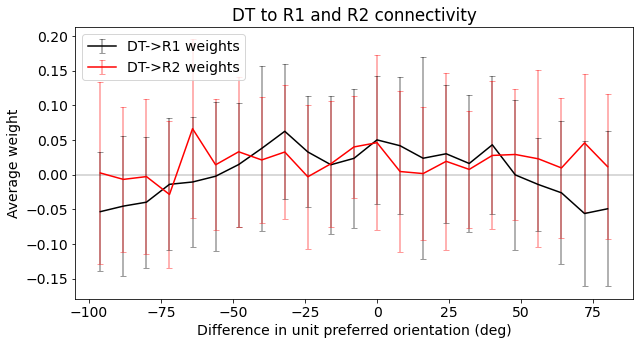

In [320]:
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_DT_connplot_graph(-1)

plt.figure(figsize=(10, 5))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="DT->R1 weights", capsize=3)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="DT->R2 weights", capsize=3)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'DT to R1 and R2 connectivity')
plt.legend()
plt.show()

## R1 and R2 connectivity to inputs and outputs

In [321]:
timestep = -1+delay0+hold_orientation_for+delay1+hold_orientation_for+delay2
R1_i = R1_indices[timestep]
R2_i = R2_indices[timestep]
DT_i = DT_indices[timestep]
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES

In [322]:
# uncomment for all units connectivity
# t = -1+delay0+hold_orientation_for+delay1
# R1_i = tuning_indices[t].clone()
# R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][R1_i], dim=2), dim=1)
# R1_i = R1_i.clone()[torch.argsort(R1_pref)]
# R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[t][R1_i], dim=2), dim=1)

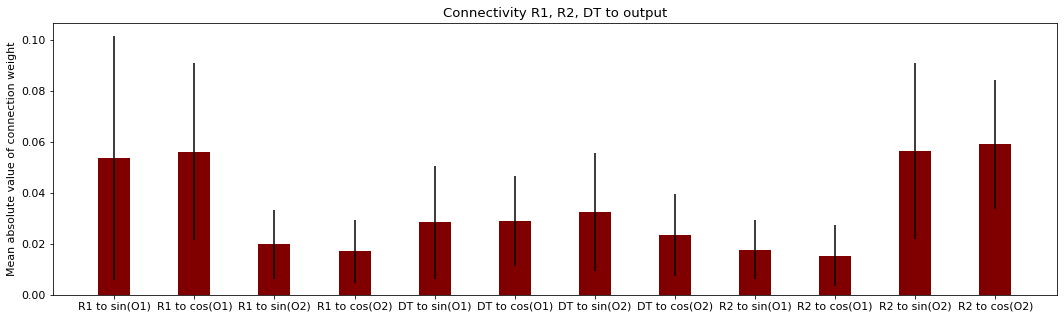

In [323]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["R1 to sin(O1)", "R1 to cos(O1)", "R1 to sin(O2)", "R1 to cos(O2)",
        "DT to sin(O1)", "DT to cos(O1)", "DT to sin(O2)", "DT to cos(O2)",
        "R2 to sin(O1)", "R2 to cos(O1)", "R2 to sin(O2)", "R2 to cos(O2)"], 
        torch.cat([torch.mean(torch.abs(model.fc_h2y.weight[:, R1_i]), dim=1),
                  torch.mean(torch.abs(model.fc_h2y.weight[:, DT_i]), dim=1),
                  torch.mean(torch.abs(model.fc_h2y.weight[:, R2_i]), dim=1)]).cpu().detach().numpy(), 
        yerr=torch.cat([torch.std(torch.abs(model.fc_h2y.weight[:, R1_i]), dim=1),
                        torch.std(torch.abs(model.fc_h2y.weight[:, DT_i]), dim=1),
                        torch.std(torch.abs(model.fc_h2y.weight[:, R2_i]), dim=1)]).cpu().detach().numpy(), 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity R1, R2, DT to output")
plt.show()

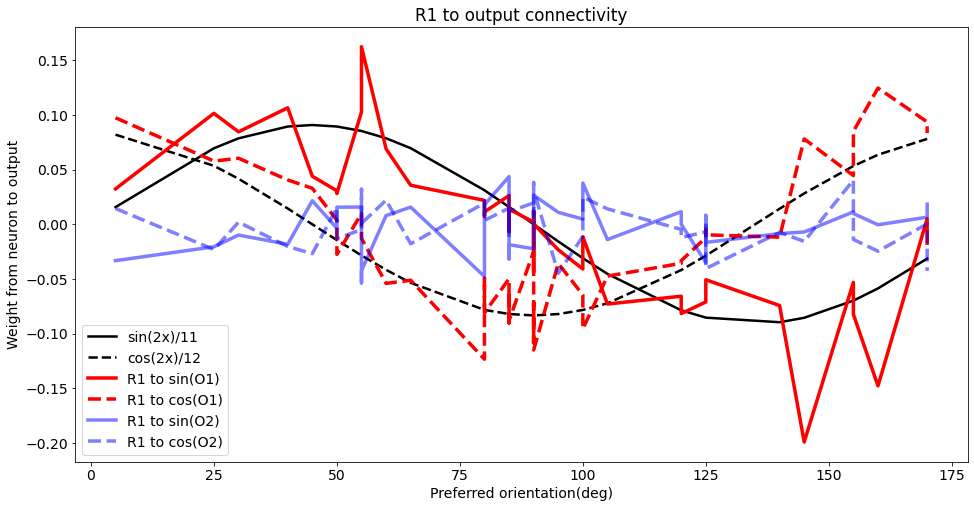

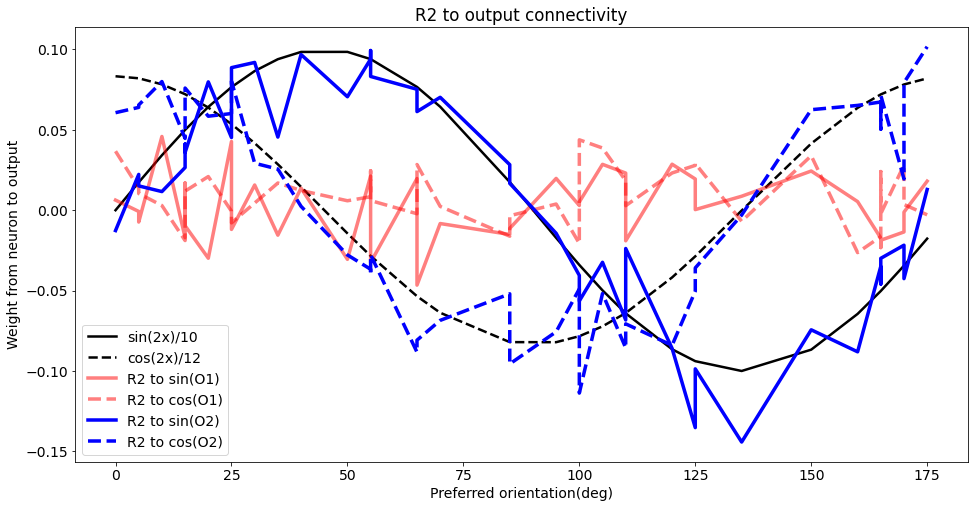

In [324]:
# find closest sin and cos
min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
for k in range(20):
    err = torch.sum((model.fc_h2y.weight[:, R1_i][0]-torch.sin(R1_pref/180*3.14*2)/k)**2)
    if err<min_err_sin: min_k_sin=k;min_err_sin=err
    err = torch.sum((model.fc_h2y.weight[:, R1_i][1]-torch.cos(R1_pref/180*3.14*2)/k)**2)
    if err<min_err_cos: min_k_cos=k;min_err_cos=err
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
plt.figure(figsize=(16, 8))
plt.plot(R1_pref.cpu().detach().numpy(), torch.sin(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
         "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
plt.plot(R1_pref.cpu().detach().numpy(), torch.cos(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
         "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][0].cpu().detach().numpy(), 
         "r-", linewidth=3.5, label="R1 to sin(O1)")
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][1].cpu().detach().numpy(), 
         "r--", linewidth=3.5, label="R1 to cos(O1)", alpha=1)
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][2].cpu().detach().numpy(), 
         "b-", linewidth=3.5, label="R1 to sin(O2)", alpha=0.5)
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][3].cpu().detach().numpy(), 
         "b--", linewidth=3.5, label="R1 to cos(O2)", alpha=0.5)

#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Preferred orientation(deg)')
plt.ylabel('Weight from neuron to output')
plt.title(f'R1 to output connectivity')
plt.legend()
plt.show()

# find closest sin and cos
min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
for k in range(20):
    err = torch.sum((model.fc_h2y.weight[:, R2_i][2]-torch.sin(R2_pref/180*3.14*2)/k)**2)
    if err<min_err_sin: min_k_sin=k;min_err_sin=err
    err = torch.sum((model.fc_h2y.weight[:, R2_i][3]-torch.cos(R2_pref/180*3.14*2)/k)**2)
    if err<min_err_cos: min_k_cos=k;min_err_cos=err
plt.figure(figsize=(16, 8))
plt.plot(R2_pref.cpu().detach().numpy(), torch.sin(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
         "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
plt.plot(R2_pref.cpu().detach().numpy(), torch.cos(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
         "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][0].cpu().detach().numpy(), 
         "r-", linewidth=3.5, label="R2 to sin(O1)", alpha=0.5)
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][1].cpu().detach().numpy(), 
         "r--", linewidth=3.5, label="R2 to cos(O1)", alpha=0.5)
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][2].cpu().detach().numpy(), 
         "b-", linewidth=3.5, label="R2 to sin(O2)")
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][3].cpu().detach().numpy(), 
         "b--", linewidth=3.5, label="R2 to cos(O2)")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Preferred orientation(deg)')
plt.ylabel('Weight from neuron to output')
plt.title(f'R2 to output connectivity')
plt.legend()
plt.show()

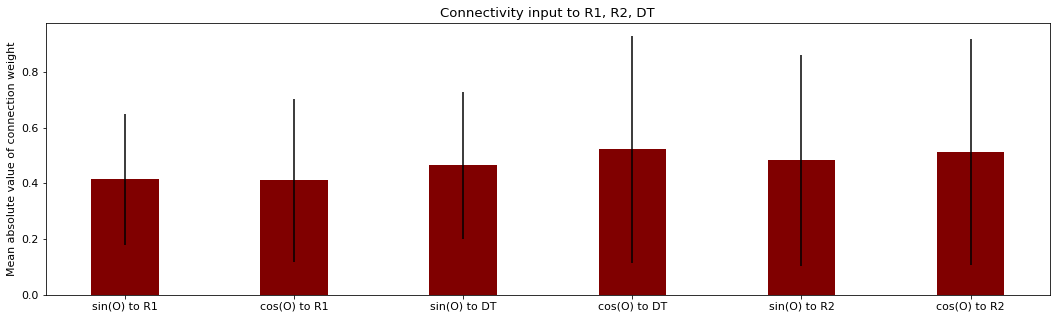

In [325]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["sin(O) to R1", "cos(O) to R1", "sin(O) to DT", "cos(O) to DT", "sin(O) to R2", "cos(O) to R2"], 
        torch.cat([torch.mean(torch.abs(model.fc_x2ah.weight[R1_indices[-1]][:, :-1].T), dim=1),
                  torch.mean(torch.abs(model.fc_x2ah.weight[DT_indices[-1]][:, :-1].T), dim=1),
                  torch.mean(torch.abs(model.fc_x2ah.weight[R2_indices[-1]][:, :-1].T), dim=1)]).cpu().detach().numpy(), 
        yerr=torch.cat([torch.std(torch.abs(model.fc_x2ah.weight[R1_indices[-1]][:, :-1].T), dim=1),
                  torch.std(torch.abs(model.fc_x2ah.weight[DT_indices[-1]][:, :-1].T), dim=1),
                  torch.std(torch.abs(model.fc_x2ah.weight[R2_indices[-1]][:, :-1].T), dim=1)]).cpu().detach().numpy(), 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.show()

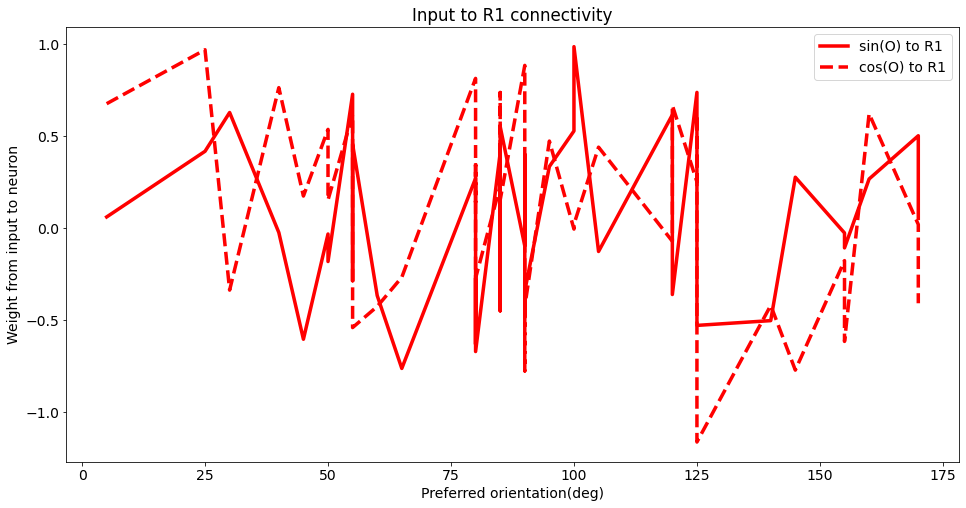

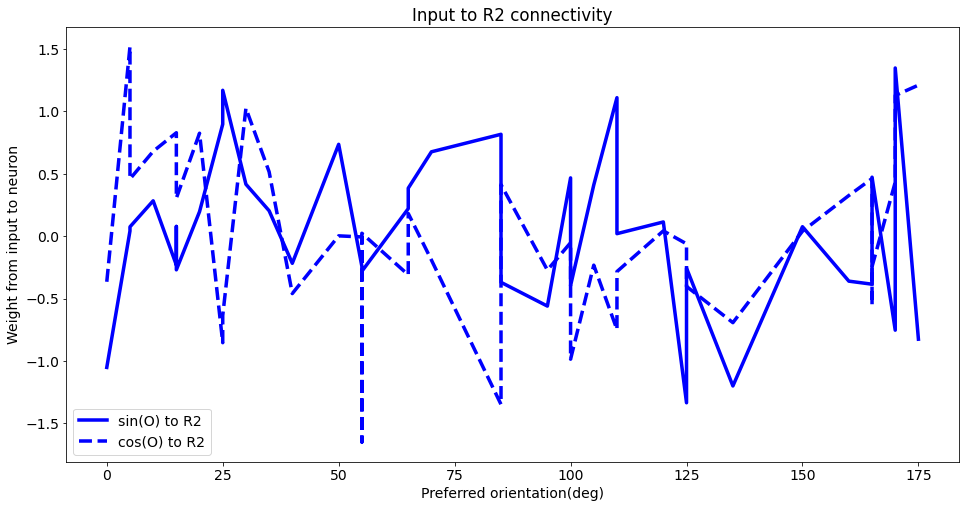

In [326]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
plt.figure(figsize=(16, 8))
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_x2ah.weight[R1_i][:, 0].cpu().detach().numpy(), 
         "r-", linewidth=3.5, label="sin(O) to R1")
plt.plot(R1_pref.cpu().detach().numpy(), model.fc_x2ah.weight[R1_i][:, 1].cpu().detach().numpy(), 
         "r--", linewidth=3.5, label="cos(O) to R1", alpha=1)
# plt.plot(R1_pref.cpu().detach().numpy(), torch.sin(R1_pref/180*3.14*2).cpu().detach().numpy()/10, 
#          "k-", linewidth=3.5, label="sin(2x)/10")
# plt.plot(R1_pref.cpu().detach().numpy(), torch.cos(R1_pref/180*3.14*2).cpu().detach().numpy()/10, 
#          "k--", linewidth=3.5, label="cos(2x)/10")

#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Preferred orientation(deg)')
plt.ylabel('Weight from input to neuron')
plt.title(f'Input to R1 connectivity')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_x2ah.weight[R2_i][:, 0].cpu().detach().numpy(), 
         "b-", linewidth=3.5, label="sin(O) to R2", alpha=1.0)
plt.plot(R2_pref.cpu().detach().numpy(), model.fc_x2ah.weight[R2_i][:, 1].cpu().detach().numpy(), 
         "b--", linewidth=3.5, label="cos(O) to R2", alpha=1.0)
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
# plt.plot(R2_pref.cpu().detach().numpy(), torch.sin(R2_pref/180*3.14*2).cpu().detach().numpy(), 
#           "k-", linewidth=3.5, label="sin(2x)/10")
# plt.plot(R2_pref.cpu().detach().numpy(), torch.cos(R2_pref/180*3.14*2).cpu().detach().numpy()/10, 
#           "k--", linewidth=3.5, label="cos(2x)/10")
plt.xlabel('Preferred orientation(deg)')
plt.ylabel('Weight from input to neuron')
plt.title(f'Input to R2 connectivity')
plt.legend()
plt.show()

## R1 and R2 connectivity over time

In [420]:
def get_title(timestep):
    if timestep >= hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2:
        return "cue2 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1+delay2:
        return "cue1 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1:
        return "delay2"
    if timestep >= hold_orientation_for+delay0+delay1:
        return "orientation2 presented"
    if timestep >= hold_orientation_for+delay0:
        return "delay1"
    if timestep >= delay0:
        return "orientation1 presented"
    return "delay0"

In [421]:
dirname = "figs5"

import pathlib
_path = pathlib.Path(f"data/{directory}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)

60(4.00%) 80(12.00%) 100(20.00%) 120(28.00%) 140(36.00%) 160(44.00%) 180(52.00%) 200(60.00%) 220(68.00%) 240(76.00%) 260(84.00%) 280(92.00%) 

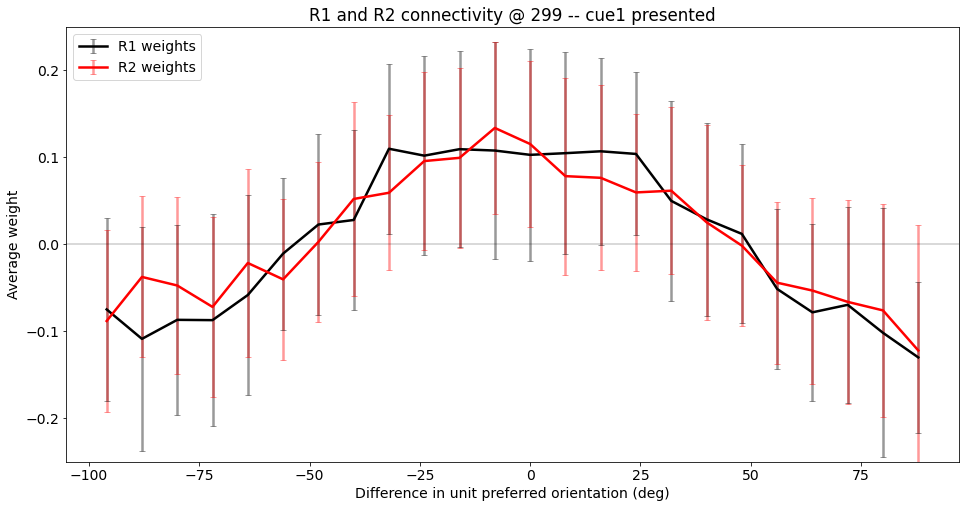

In [422]:
start_from = 50
go_to = total_time
for t in range(start_from, go_to):
    plt.close('all')

    r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(t)

    plt.figure(figsize=(16, 8))
    markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', linewidth=2.5, label="R1 weights", capsize=3)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', linewidth=2.5, label="R2 weights", capsize=3)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.ylim(-0.25, 0.25)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'R1 and R2 connectivity @ {t} -- {get_title(t)}')
    plt.legend(loc="upper left")
    plt.savefig(f"data/{directory}/{dirname}/fig{t:03}.png")
    if t % 20 == 0: print(f"{t}({(t-start_from)/(go_to-start_from)*100:.2f}%)", end=" ")

In [423]:
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i 'data/{directory}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p data/{directory}/{dirname}/0.mp4")

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

## Resetting units

In [135]:
def errors_when_reset_units_at_timestep(units_i, timestep, mean=False, res=1):
    res = res # resolution (1 to 180)
    batch = megabatch_input, megabatch_target, megabatch_mask
    sbatch = batch
    soutput = megabatch_output[0][::res], megabatch_output[1][::res]
    sbatch = batch[0][::res], batch[1][::res], batch[2][::res]
    reset_mean = torch.zeros(total_time, dim_recurrent, dtype=int)
    reset_mean[timestep][units_i] = 1
    soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), 
                                       reset_units=reset_mean, reset_to="mean" if mean else 0)
    error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
            sbatch[2] == 1)
    error_o1_reset = (error[0]+error[1]).item()
    error_o2_reset = (error[2]+error[3]).item()
        
    
    return error_o1_reset, error_o2_reset, soutput_reset

In [136]:
error = torch.sum((megabatch_output[0][megabatch_mask == 1] - megabatch_target[megabatch_mask == 1]) ** 2, dim=0) / torch.sum(megabatch_mask == 1)
O1_error_no_reset = (error[0]+error[1]).item()
O2_error_no_reset = (error[2]+error[3]).item()

### Resetting R1 and R2 at every timestep

In [137]:
time_res = 10
ori_res = 18

O1_error_O1_reset, O2_error_O1_reset, O1_error_O2_reset, O2_error_O2_reset = [], [], [], []
O1_error_DT_reset, O2_error_DT_reset = [], []
O1_error_R1DT_reset, O2_error_R1DT_reset = [], []
timesteps = range(0, total_time, time_res)
for timestep in timesteps:
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(R1_indices[-1], timestep, res=ori_res)
    O1_error_O1_reset.append(e_o1)
    O2_error_O1_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(R2_indices[-1], timestep, res=ori_res)
    O1_error_O2_reset.append(e_o1)
    O2_error_O2_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(DT_indices[-1], timestep, res=ori_res)
    O1_error_DT_reset.append(e_o1)
    O2_error_DT_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(torch.cat((DT_indices[-1], R1_indices[-1])), timestep, res=ori_res)
    O1_error_R1DT_reset.append(e_o1)
    O2_error_R1DT_reset.append(e_o2)
O1_error_O1_reset = np.array(O1_error_O1_reset)
O2_error_O1_reset = np.array(O2_error_O1_reset)
O1_error_O2_reset = np.array(O1_error_O2_reset)
O2_error_O2_reset = np.array(O2_error_O2_reset)
O1_error_DT_reset = np.array(O1_error_DT_reset)
O2_error_DT_reset = np.array(O2_error_DT_reset)
O1_error_R1DT_reset = np.array(O1_error_R1DT_reset)
O2_error_R1DT_reset = np.array(O2_error_R1DT_reset)

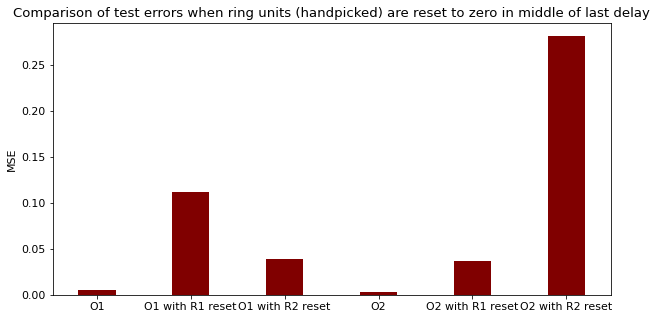

In [138]:
timestep = delay0 + hold_orientation_for*2 + delay1 + delay2//2
timestep = timestep // time_res #res
timestep_desc = "in middle of last delay"

to_pow = 1.0
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(["O1", "O1 with R1 reset", "O1 with R2 reset", "O2", "O2 with R1 reset", "O2 with R2 reset"], 
        [O1_error_no_reset**to_pow, O1_error_O1_reset[timestep]**to_pow, O1_error_O2_reset[timestep]**to_pow, 
         O2_error_no_reset**to_pow, O2_error_O1_reset[timestep]**to_pow, O2_error_O2_reset[timestep]**to_pow], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("MSE")
plt.title("Comparison of test errors when ring units (handpicked) are reset to zero " + timestep_desc)
plt.show()

findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.


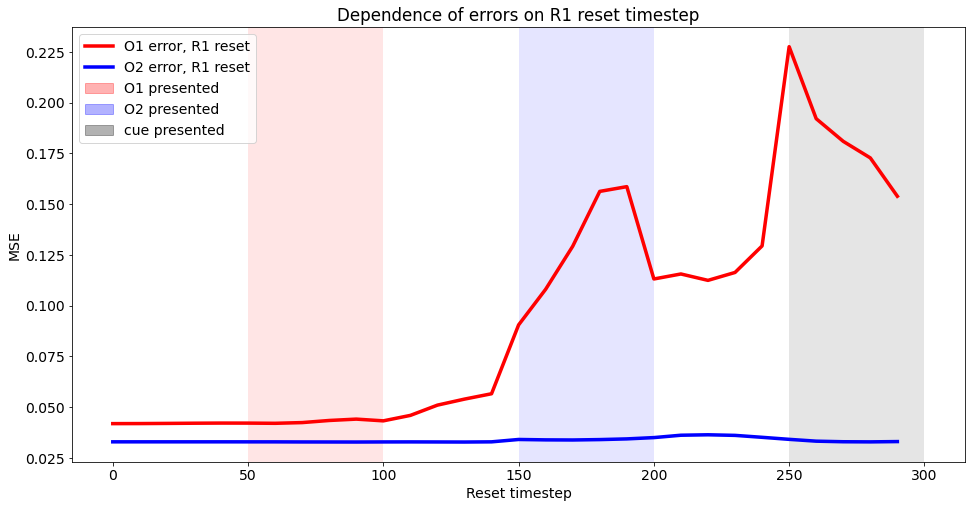

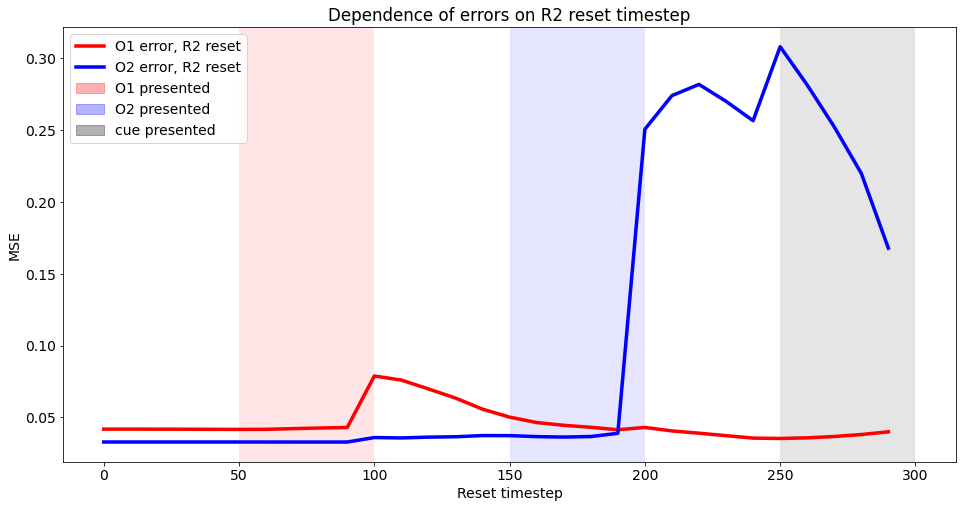

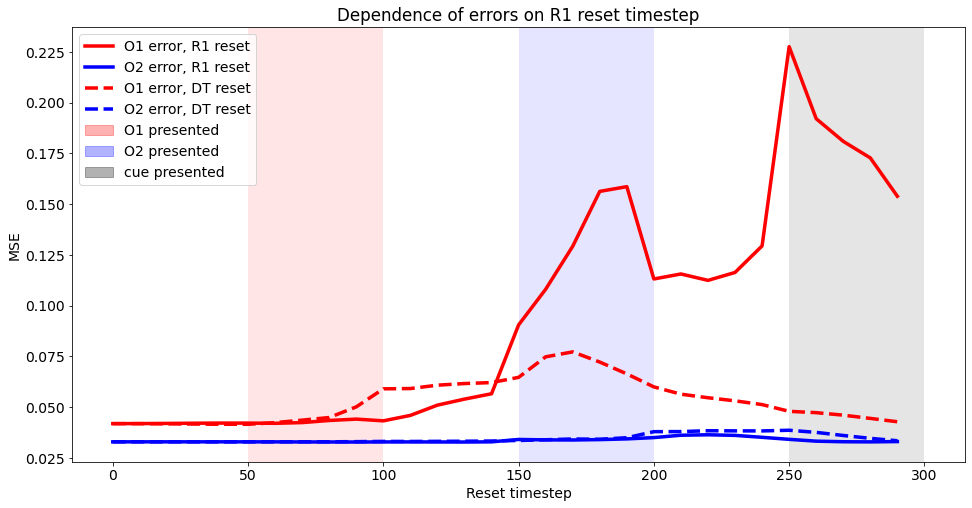

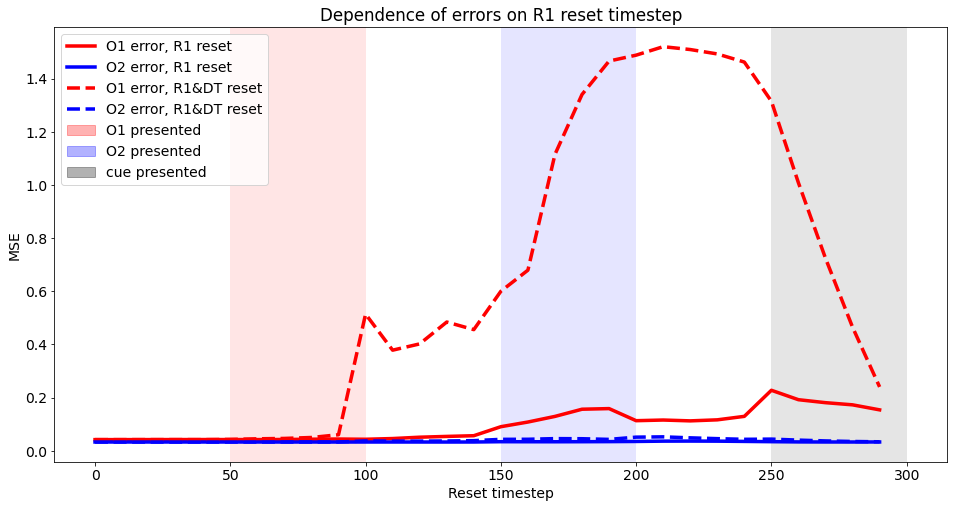

In [139]:
font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.figure(figsize=(16, 8))
plt.plot(timesteps, O1_error_O1_reset, "r-", linewidth=3.5, label="O1 error, R1 reset")
#plt.plot(timesteps, O1_error_O1_reset_O2, "r--", linewidth=3.5, label="O1 error to O2, R1 reset")
plt.plot(timesteps, O2_error_O1_reset, "b-", linewidth=3.5, label="O2 error, R1 reset")
#plt.plot(timesteps, O1_error_DT_reset, "r--", markersize=10, label="R1 error, DT reset")
#plt.plot(timesteps, O2_error_DT_reset, "b--", markersize=10, label="R2 error, DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(timesteps, O1_error_O2_reset, "r-", linewidth=3.5, label="O1 error, R2 reset")
plt.plot(timesteps, O2_error_O2_reset, "b-", linewidth=3.5, label="O2 error, R2 reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('MSE')
plt.title(f'Dependence of errors on R2 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(timesteps, O1_error_O1_reset, "r-", linewidth=3.5, label="O1 error, R1 reset")
plt.plot(timesteps, O2_error_O1_reset, "b-", linewidth=3.5, label="O2 error, R1 reset")
plt.plot(timesteps, O1_error_DT_reset, "r--", linewidth=3.5, label="O1 error, DT reset")
plt.plot(timesteps, O2_error_DT_reset, "b--", linewidth=3.5, label="O2 error, DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(timesteps, O1_error_O1_reset, "r-", linewidth=3.5, label="O1 error, R1 reset")
plt.plot(timesteps, O2_error_O1_reset, "b-", linewidth=3.5, label="O2 error, R1 reset")
plt.plot(timesteps, O1_error_R1DT_reset, "r--", linewidth=3.5, label="O1 error, R1&DT reset")
plt.plot(timesteps, O2_error_R1DT_reset, "b--", linewidth=3.5, label="O2 error, R1&DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

## Experiments w/ Network

In [116]:
def step(h, ah, input):
    ah = ah + (model.dt / model.Tau) * (-ah + model.fc_h2ah(h) + model.fc_x2ah(input))
    h = models.computef(ah, model.nonlinearity)
    return h, ah
def output(h):
    return model.fc_h2y(h)
def output_graph(h, dotted=None, dotted_label="input", save=None):
    trig = output(h).cpu().detach().numpy()
    o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2
    o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2
    #return o1, o2#output(h)
    
    plt.figure(figsize=(3, 3))
    # plt.plot([-trig[1], trig[1]], [-trig[0], trig[0]], "r-", linewidth=3.5)
    # plt.plot([-trig[3], trig[3]], [-trig[2], trig[2]], "b-", linewidth=3.5)
    r1 = (trig[0]**2+trig[1]**2)**0.5
    r2 = (trig[2]**2+trig[3]**2)**0.5
    if dotted is not None:
        theta = dotted/180*math.pi
        plt.plot([-math.cos(theta), math.cos(theta)], [-math.sin(theta), math.sin(theta)], "k--", linewidth=3.5, label=dotted_label, alpha=0.7)
    plt.plot([-math.cos(o1)*r1, math.cos(o1)*r1], [-math.sin(o1)*r1, math.sin(o1)*r1], "r-", linewidth=3.5, label="O1")
    plt.plot([-math.cos(o2)*r2, math.cos(o2)*r2], [-math.sin(o2)*r2, math.sin(o2)*r2], "b-", linewidth=3.5, label="O2")
    plt.axis('equal')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend(loc='upper left')
    #plt.show()
    return o1 * 180 / math.pi, o2 * 180 / math.pi
def output_hr(h):
    trig = output(h).cpu().detach().numpy()
    o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2
    o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2
    #return o1, o2#output(h)
    return o1 * 180 / math.pi, o2 * 180 / math.pi 
def init():
    ah = torch.zeros(dim_recurrent)
    h = models.computef(ah, model.nonlinearity)
    return h, ah
def restore_model():
    model.load_state_dict(state_dict)

In [117]:
def hold(h, ah, orientation=None, cue=False, clamp_r1=False, clamp_dt=False, clamp_r2=False, t=50, return_graph=True):
    for i in range(t): 
        input = input_ori[orientation].clone() if orientation is not None else input_del.clone()
        #input = input.clone()
        if cue: input[-1] = 1
        
        h, ah = step(h, ah, input)
        if clamp_dt:
            ah[DT_indices[-1]] = 0
        if clamp_r1:
            ah[R1_indices[-1]] = 0
        if clamp_r2:
            ah[R2_indices[-1]] = 0
    return h, ah, output_graph(h, dotted=orientation) if return_graph else None
def hold_measure_error(h, ah, orientation=None, cue=False, clamp_r1=False, clamp_dt=False, clamp_r2=False, t=50, return_graph=True, o1_target=None, o2_target=None):
    error_o1 = 0
    error_o2 = 0
    for i in range(t): 
        input_s = input_ori[orientation].clone() if orientation is not None else input_del.clone()
        #input_s = input_s
        if cue: input_s[-1] = 1
        
        h, ah = step(h, ah, input_s)
        if clamp_dt:
            ah[DT_indices[-1]] = 0
        if clamp_r1:
            ah[R1_indices[-1]] = 0
        if clamp_r2:
            ah[R2_indices[-1]] = 0
        
        trig = output(h).cpu().detach().numpy()
        o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2 * 180 / math.pi
        o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2 * 180 / math.pi
        error_o1 += min((o1-o1_target)**2, (o1-o1_target+180)**2)
        error_o2 += min((o2-o2_target)**2, (o2-o2_target+180)**2)
    error_o1 = math.sqrt(error_o1 / 50)
    error_o2 = math.sqrt(error_o2 / 50)
    if o1_target is None: error_o1=0    
    if o2_target is None: error_o2=0    
    return h, ah, error_o1, error_o2, output_graph(h, dotted=orientation) if return_graph else None

In [118]:
def remove_connections(from_u, to_u):
    if type(from_u) is str and from_u=="IN":
        model.fc_x2ah.weight[to_u, :] = 0
        return
    if type(to_u) is str and to_u=="OUT":
        model.fc_h2y.weight[:, from_u] = 0
        return
    for i in (from_u):
        for j in (to_u):
            model.fc_h2ah.weight[j, i] = 0

In [129]:
input_ori = []
for i in range(181): input_ori.append(task._input_rates(i, simple=True))
input_del = torch.zeros(3)
input_cue = torch.tensor([0, 0, 1.])
R1_i = R1_indices[-1-hold_cue_for]
R2_i = R2_indices[-1-hold_cue_for]
DT_i = DT_indices[-1-hold_cue_for]

In [122]:
restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, R2_indices[-1]] = 0
    pass
orientation = 50

h, ah = init()
h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False)
h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=False)
h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False)
h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation, o2_target=orientation)
plt.close('all')
e_o1, e_o2

(7.703505056323233, 3.900713585446447)

Average error when DT units clamped to 0.

In [126]:
restore_model()
use_delay=True
cue=True
res = 10
DATA_FULL_TASK = {}
print(f"FULL TASK: {'DEL->' if use_delay else ''}O1->DEL->O2->DEL->ASK {'(with cue)' if cue else '(no cue)'}")
print (" --- ")
restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
DATA_FULL_TASK["baseline"] = e_o1_t, e_o2_t
print(f"baseline: {e_o1_t, e_o2_t}")
print (" --- ")
restore_model()
with torch.no_grad():
    model.fc_h2y.weight[:, DT_i] = 0
    #for i in (DT_indices[-1]):
    #    for j in (u2):
    #        model.fc_h2ah.weight[j, i] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed DT->OUT:", (e_o1_t, e_o2_t))
print (" --- ")
restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, DT_i] = 0
    model.fc_x2ah.weight[R1_indices[-1], :] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed IN->R1:", (e_o1_t, e_o2_t))
print (" --- ")
restore_model()
with torch.no_grad():
    model.fc_h2y.weight[:, DT_i] = 0
    model.fc_x2ah.weight[R1_indices[-1], :] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed IN->R1 and DT->OUT:", (e_o1_t, e_o2_t))
print (" --- ")

FULL TASK: DEL->O1->DEL->O2->DEL->ASK (with cue)
 --- 
baseline: (1.9842148532496495, 1.3753615703153603)
 --- 
removed DT->OUT: (3.481795989040905, 2.9749975598076777)
 --- 
removed IN->R1: (15.673233878524313, 2.111013030452189)
 --- 
removed IN->R1 and DT->OUT: (16.601773312345856, 3.413789227086233)
 --- 


In [124]:
restore_model()
with torch.no_grad():
    model.fc_h2y.weight[:, DT_i] = 0
    model.fc_x2ah.weight[R1_indices[-1], :] = 0
    #remove_connections(R1_i, R2_i)
    remove_connections(R2_i, R1_i)
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed IN->R1 and DT->OUT and R1-R2 and R2-R1:", (e_o1_t, e_o2_t))

removed IN->R1 and DT->OUT and R1-R2 and R2-R1: (20.890115370659085, 7.038063085579303)


### Zeroing out weights

In [123]:
restore_model()
with torch.no_grad():
    model.fc_x2ah.weight[DT_indices[-1], :] = 0
    #model.fc_x2ah.weight[R1_indices[-1], :] = 0
    #model.fc_h2ah.weight[R2_i, :][:, DT_i] = 0
    #model.fc_h2ah.weight[DT_i, :][:, R2_i] = 0
    #model.fc_h2ah.weight[R2_i, :][:, R2_i] = 0
    pass

e_o1_t, e_o2_t = 0, 0
for orientation in range(181):
    h, ah = init()
    #for i in range(50): h, ah = step(h, ah, input_del)
    h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=False, return_graph=False)
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
    h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation, o2_target=orientation, return_graph=False)
    e_o1_t += e_o1
    e_o2_t += e_o2
e_o1_t /= 180
e_o2_t /= 180
e_o1_t, e_o2_t

(10.197795685309927, 2.778573460244814)

In [128]:
DATA_FULL_TASK = {}
use_delay=True
cue=True
remove_dt_out=False
res = 10

print(f"FULL TASK: {'DEL->' if use_delay else ''}O1->DEL->O2->DEL->ASK {'(with cue)' if cue else '(no cue)'}")
if remove_dt_out:
    print("Removed all DT->OUTPUT connections")
print (" --- ")
restore_model()
with torch.no_grad():
    if remove_dt_out: model.fc_h2y.weight[:, DT_i] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
DATA_FULL_TASK["baseline"] = e_o1_t, e_o2_t
print(f"baseline: {e_o1_t, e_o2_t}")
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    for i2, u2 in enumerate(unit_ids):
        restore_model()
        with torch.no_grad():
            #model.fc_x2ah.weight[R2_indices[-1], :] = 0
            #model.fc_h2ah.weight[R2_i, :][:, DT_i] = 0
            if remove_dt_out: model.fc_h2y.weight[:, DT_i] = 0
            for i in (u1):
                for j in (u2):
                    model.fc_h2ah.weight[j, i] = 0
            #model.fc_h2ah.weight[R2_i, :][:, R2_i] = 0
            pass

        e_o1_t, e_o2_t = 0, 0
        for orientation1 in range(0, 181, res):
            for orientation2 in range(0, 181, res):
                h, ah = init()
                if use_delay: 
                    for i in range(50): h, ah = step(h, ah, input_del)
                h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
                h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
                h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
                h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
                h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
                e_o1_t += e_o1
                e_o2_t += e_o2
        e_o1_t /= 180 * 180 / res / res
        e_o2_t /= 180 * 180 / res / res
        print(f"from {title[i1]} to {title[i2]}: {e_o1_t, e_o2_t}")
        DATA_FULL_TASK[f"{title[i1]}->{title[i2]}"] = e_o1_t, e_o2_t
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    restore_model()
    with torch.no_grad():
        if remove_dt_out: model.fc_h2y.weight[:, DT_i] = 0
        model.fc_x2ah.weight[u1, :] = 0
        pass

    e_o1_t, e_o2_t = 0, 0
    for orientation1 in range(0, 181, res):
        for orientation2 in range(0, 181, res):
            h, ah = init()
            if use_delay: 
                for i in range(50): h, ah = step(h, ah, input_del)
            h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
            e_o1_t += e_o1
            e_o2_t += e_o2
    e_o1_t /= 180 * 180 / res / res
    e_o2_t /= 180 * 180 / res / res
    print(f"from input to {title[i1]}: {e_o1_t, e_o2_t}")
    DATA_FULL_TASK[f"input->{title[i1]}"] = e_o1_t, e_o2_t
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    restore_model()
    with torch.no_grad():
        if remove_dt_out: model.fc_h2y.weight[:, DT_i] = 0
        model.fc_h2y.weight[:, u1] = 0
        pass

    e_o1_t, e_o2_t = 0, 0
    for orientation1 in range(0, 181, res):
        for orientation2 in range(0, 181, res):
            h, ah = init()
            if use_delay: 
                for i in range(50): h, ah = step(h, ah, input_del)
            h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
            e_o1_t += e_o1
            e_o2_t += e_o2
    e_o1_t /= 180 * 180 / res / res
    e_o2_t /= 180 * 180 / res / res
    print(f"from {title[i1]} to output: {e_o1_t, e_o2_t}")
    DATA_FULL_TASK[f"{title[i1]}->output"] = e_o1_t, e_o2_t

FULL TASK: DEL->O1->DEL->O2->DEL->ASK (with cue)
 --- 
baseline: (1.9842148532496495, 1.3753615703153603)
 --- 
from R1 to R1: (43.54821821867537, 3.9940967754447927)
from R1 to R2: (4.210953512256075, 6.329988249212776)
from R1 to DT: (20.300341596348982, 6.768338355703141)
from R2 to R1: (16.42916045161356, 2.116661945844178)
from R2 to R2: (9.398783948126631, 34.93213054266409)
from R2 to DT: (20.8999748160703, 9.663208719364773)
from DT to R1: (57.11117365145302, 3.784186996945393)
from DT to R2: (6.299568024673313, 11.05593435468243)
from DT to DT: (26.889285716525126, 4.346885884212102)
 --- 
from input to R1: (15.673233878524313, 2.111013030452189)
from input to R2: (10.16376684329458, 41.97834101711876)
from input to DT: (6.434817412855061, 4.235693147932239)
 --- 
from R1 to output: (13.47977024475931, 1.537095946750391)
from R2 to output: (1.9574616095993855, 11.207883346568051)
from DT to output: (3.481795989040905, 2.9749975598076777)


In [28]:
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    restore_model()
    with torch.no_grad():
        model.fc_h2y.weight[:, u1] = 0
        model.fc_h2y.weight[:, DT_i] = 0
        pass

    e_o1_t, e_o2_t = 0, 0
    for orientation1 in range(0, 181, res):
        for orientation2 in range(0, 181, res):
            h, ah = init()
            #for i in range(50): h, ah = step(h, ah, input_del)
            h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
            e_o1_t += e_o1
            e_o2_t += e_o2
    e_o1_t /= 180 * 180 / res / res
    e_o2_t /= 180 * 180 / res / res
    print(f"from {title[i1]}&DT to output: {e_o1_t, e_o2_t}")

from R1&DT to output: (46.693136298556745, 2.810797088038345)
from R2&DT to output: (3.7235959403512178, 46.00333131241621)
from DT&DT to output: (4.949108067282458, 2.5299714024656224)


In [29]:
DATA_PART_TASK = {}
use_delay=False
cue=False
res = 6
print(f"PART TASK: {'DEL->' if use_delay else ''}O1->DEL->ASK {'(with cue)' if cue else '(no cue)'}")
print (" --- ")
restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    h, ah = init()
    if use_delay: for i in range(50): h, ah = step(h, ah, input_del)
    h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
    h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation1, return_graph=False, cue=cue)
    e_o1_t += e_o1
    e_o2_t += e_o2
e_o1_t /= 180 / res
e_o2_t /= 180 / res
print(f"baseline: {e_o1_t, e_o2_t}")
DATA_PART_TASK["baseline"] = e_o1_t, e_o2_t
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    for i2, u2 in enumerate(unit_ids):
        restore_model()
        with torch.no_grad():
            #model.fc_x2ah.weight[R2_indices[-1], :] = 0
            #model.fc_h2ah.weight[R2_i, :][:, DT_i] = 0
            for i in (u1):
                for j in (u2):
                    model.fc_h2ah.weight[j, i] = 0
            #model.fc_h2ah.weight[R2_i, :][:, R2_i] = 0
            pass

        e_o1_t, e_o2_t = 0, 0
        for orientation1 in range(0, 181, res):
            h, ah = init()
            if use_delay: for i in range(50): h, ah = step(h, ah, input_del)
            h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
            h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation1, return_graph=False, cue=cue)
            e_o1_t += e_o1
            e_o2_t += e_o2
        e_o1_t /= 180 / res
        e_o2_t /= 180 / res
        print(f"from {title[i1]} to {title[i2]}: {e_o1_t, e_o2_t}")
        DATA_PART_TASK[f"{title[i1]}->{title[i2]}"] = e_o1_t, e_o2_t
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    restore_model()
    with torch.no_grad():
        model.fc_x2ah.weight[u1, :] = 0
        pass

    e_o1_t, e_o2_t = 0, 0
    for orientation1 in range(0, 181, res):
        h, ah = init()
        if use_delay: for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation1, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
    e_o1_t /= 180 / res
    e_o2_t /= 180 / res
    print(f"from input to {title[i1]}: {e_o1_t, e_o2_t}")
    DATA_PART_TASK[f"input->{title[i1]}"] = e_o1_t, e_o2_t
print (" --- ")
unit_ids = [R1_i, R2_i, DT_i]
title = "R1", "R2", "DT"
for i1, u1 in enumerate(unit_ids):
    restore_model()
    with torch.no_grad():
        model.fc_h2y.weight[:, u1] = 0
        pass

    e_o1_t, e_o2_t = 0, 0
    for orientation1 in range(0, 181, res):
        h, ah = init()
        if use_delay: for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation1, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
    e_o1_t /= 180 / res
    e_o2_t /= 180 / res
    print(f"from {title[i1]} to output: {e_o1_t, e_o2_t}")
    DATA_PART_TASK[f"{title[i1]}->output"] = e_o1_t, e_o2_t

SyntaxError: invalid syntax (1430137666.py, line 13)

### Video of clamped units

In [445]:
dirname = "figs_lines_nodelay"

import pathlib
_path = pathlib.Path(f"data/{directory}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)

In [441]:
orientations = [0]*50 + [None]*50 + [90]*50 + [None]*50 + [45]*50 + [None]*50 + [0]*50 + [None]*50

0(0.00%) 20(5.00%) 40(10.00%) 60(15.00%) 80(20.00%) 100(25.00%) 120(30.00%) 140(35.00%) 160(40.00%) 180(45.00%) 200(50.00%) 220(55.00%) 240(60.00%) 260(65.00%) 280(70.00%) 300(75.00%) 320(80.00%) 340(85.00%) 360(90.00%) 380(95.00%) 

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

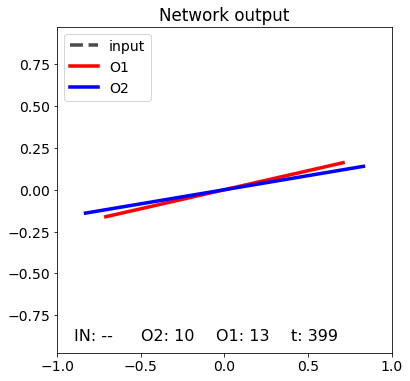

In [442]:
h, ah = init()
#for i in range(50): h, ah = step(h, ah, input_del)
#h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=50)
for t in range(len(orientations)):
    orientation = orientations[t]
    dotted=orientation
    
    h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=False, clamp_r1=False, return_graph=False, t=1)
    
    trig = output(h).cpu().detach().numpy()
    o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2
    o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2
    #return o1, o2#output(h)

    plt.close('all')
    plt.figure(figsize=(6, 6))
    # plt.plot([-trig[1], trig[1]], [-trig[0], trig[0]], "r-", linewidth=3.5)
    # plt.plot([-trig[3], trig[3]], [-trig[2], trig[2]], "b-", linewidth=3.5)
    r1 = (trig[0]**2+trig[1]**2)**0.5
    r2 = (trig[2]**2+trig[3]**2)**0.5
    if dotted is not None:
        theta = dotted/180*math.pi
        plt.plot([-math.cos(theta), math.cos(theta)], [-math.sin(theta), math.sin(theta)], "k--", linewidth=3.5, label="input", alpha=0.7)
    else:
        plt.plot([0, 0], [0, 0], "k--", linewidth=3.5, label="input", alpha=0.7)
    plt.plot([-math.cos(o1)*r1, math.cos(o1)*r1], [-math.sin(o1)*r1, math.sin(o1)*r1], "r-", linewidth=3.5, label="O1")
    plt.plot([-math.cos(o2)*r2, math.cos(o2)*r2], [-math.sin(o2)*r2, math.sin(o2)*r2], "b-", linewidth=3.5, label="O2")
    plt.axis('equal')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title("Network output")
    plt.text(-0.9, -0.9, f'IN: {orientation if orientation is not None else "--"}', fontsize = 16)
    plt.text(-0.5, -0.9, f'O2: {o2*180/math.pi:.0f}', fontsize = 16)
    plt.text(-0.05, -0.9, f'O1: {o1*180/math.pi:.0f}', fontsize = 16)
    plt.text(0.4, -0.9, f't: {t}', fontsize = 16)
    plt.legend(loc='upper left')

    plt.savefig(f"data/{directory}/{dirname}/fig{t:03}.png")
    if t % 20 == 0: print(f"{t}({(t-0)/(len(orientations)-0)*100:.2f}%)", end=" ")
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i 'data/{directory}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p data/{directory}/{dirname}/0.mp4")

(80.71334634483134, 11.609719998460914)

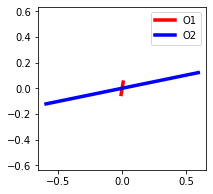

In [862]:
for i in range(100): 
    h, ah = step(h, ah, input_ori[0])
    ah[DT_indices[-1]] = 0
    ah[R1_indices[-1]] = 0
output_graph(h)

From R1 to R1: 0.1111394539475441
From R1 to R2: 0.08371394127607346
From R1 to DT: 0.09326545894145966
From R2 to R1: 0.08151405304670334
From R2 to R2: 0.09883604943752289
From R2 to DT: 0.08978260308504105
From DT to R1: 0.0968443974852562
From DT to R2: 0.08788518607616425
From DT to DT: 0.0921688824892044


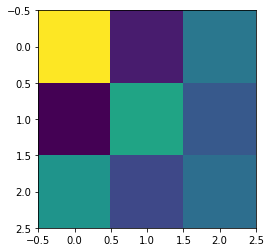

In [949]:
arrays = [R1_i, R2_i, DT_indices[-1]]
labels = ["R1", "R2", "DT"]
result = np.zeros((3, 3))
for i in range(len(arrays)):
    for j in range(len(arrays)):
        print(f"From {labels[i]} to {labels[j]}: {torch.mean(torch.abs(model.fc_h2ah.weight[arrays[j], :][:, arrays[i]]))}")
        result[i][j] = torch.mean(torch.abs(model.fc_h2ah.weight[arrays[j], :][:, arrays[i]]))
plt.imshow(result)

In [23]:
hstore = []  # (numtrials, numT, dim_recurrent)
pastore = []
for t in range(numT):
    ah = ah + (dt / Tau) * (-ah + self.fc_h2ah(h) + self.fc_x2ah(
        input[:, t]))  # ah[t] = ah[t-1] + (dt/Tau) * (-ah[t-1] + Wahh @ h[t−1] + 􏰨Wahx @ x[t] +  bah)
    # h = self.nonlinearity(ah)  +  bhneverlearn[:,t,:]# bhneverlearn has shape (numtrials, numT, dim_recurrent)

    if reset_units is not None:
        if reset_to.lower() == "mean":
            ah[:, reset_units[t] == 1] = torch.mean(ah[:, reset_units[t] == 1], dim=1).reshape(-1, 1).repeat(1, torch.sum(reset_units[t]))
        else:
            ah[:, reset_units[t] == 1] = reset_to

    pastore.append(ah)
    h = computef(ah, self.nonlinearity) + bhneverlearn[:, t, :]  # bhneverlearn has shape (numtrials, numT, dim_recurrent)
    hstore.append(h)  # hstore += [h]
hstore = torch.stack(hstore,
                     dim=1)

NameError: name 'numT' is not defined

### Reset all DT units always?

In [ ]:
def errors_when_reset_units_at_timestep(units_i, timestep, mean=False, res=1):
    res = res # resolution (1 to 180)
    batch = megabatch_input, megabatch_target, megabatch_mask
    sbatch = batch
    soutput = megabatch_output[0][::res], megabatch_output[1][::res]
    sbatch = batch[0][::res], batch[1][::res], batch[2][::res]
    reset_mean = torch.zeros(total_time, dim_recurrent, dtype=int)
    reset_mean[timestep][units_i] = 1
    if mean:
        soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), 
                                       reset_mean=reset_mean)
    else:
        soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), 
                                       reset_zero=reset_mean)
    error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
            sbatch[2] == 1)
    error_o1_reset = (error[0]+error[1]).item()
    error_o2_reset = (error[2]+error[3]).item()
    return error_o1_reset, error_o2_reset

## Tunings

In [327]:
def get_tuning_heatmaps(timestep, timestep_description, data_all=data_all, sor_i=sor_i):
    plt.close('all')
    
    if sor_i is None:
        sor_i = megabatch_tuningindices[timestep]
    
    n = len(sor_i)
    sqt = math.ceil(n ** 0.5)
    fig, ax = plt.subplots(nrows=math.ceil(n/sqt), ncols=sqt, figsize=(12, 12))
    for a in ax.ravel():
        a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        #a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        a.imshow(data_all[timestep][sor_i][i].detach().numpy(), vmin=0, vmax=1)

        #uncomment to see which unit has which id
        #a.title.set_visible(True)
        #a.set_title(sor_i[i])
    plt.tight_layout()
    st = fig.suptitle(f"Tuning to orientations {timestep_description}", fontsize=20)
    fig.supxlabel('Orientation2 (0 to 180 deg)', fontsize=14)
    fig.supylabel('Orientation1 (0 to 180 deg)', fontsize=14)
    fig.subplots_adjust(top=0.95, left=0.04, bottom=0.04)
    return fig
def get_tuning_curves(timestep, timestep_description, data_all=data_all, sor_i=sor_i):
    plt.close('all')
    
    if sor_i is None:
        sor_i = megabatch_tuningindices[timestep]
        
    n = len(sor_i)
    sqt = math.ceil(n ** 0.5)
    fig, ax = plt.subplots(nrows=math.ceil(n/sqt), ncols=sqt, figsize=(12, 12))
    for a in ax.ravel():
        a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        #a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        #a.plot(range(180), torch.mean(data_all[timestep][sor_i][i], axis=0).detach().numpy(), "k")

        x = ORI_SET
        y = torch.mean(data_all[timestep][sor_i][i], axis=1).detach().numpy()
        e = torch.std(data_all[timestep][sor_i][i], dim=1).detach().numpy()
        markers, caps, bars = a.errorbar(x, y, e, fmt="r", ecolor="r")
        [bar.set_alpha(0.05) for bar in bars]
        [cap.set_alpha(0) for cap in caps]

        x = ORI_SET
        y = torch.mean(data_all[timestep][sor_i][i], axis=0).detach().numpy()
        e = torch.std(data_all[timestep][sor_i][i], dim=0).detach().numpy()
        markers, caps, bars = a.errorbar(x, y, e, fmt="k", ecolor="k")
        [bar.set_alpha(0.05) for bar in bars]
        [cap.set_alpha(0) for cap in caps]

        a.set_ylim(0, 1)
    plt.tight_layout()
    st = fig.suptitle(f"Tuning to orientations {timestep_description}", fontsize=20)
    #st.set_y(0.95)
    fig.supxlabel('Orientation (0 to 180 deg), orientation1 (red) and orientation2 (black)', fontsize=14)
    fig.supylabel('Average activation (0 to 1), with standard deviation', fontsize=14)
    fig.subplots_adjust(top=0.95, left=0.04, bottom=0.04)
    return fig

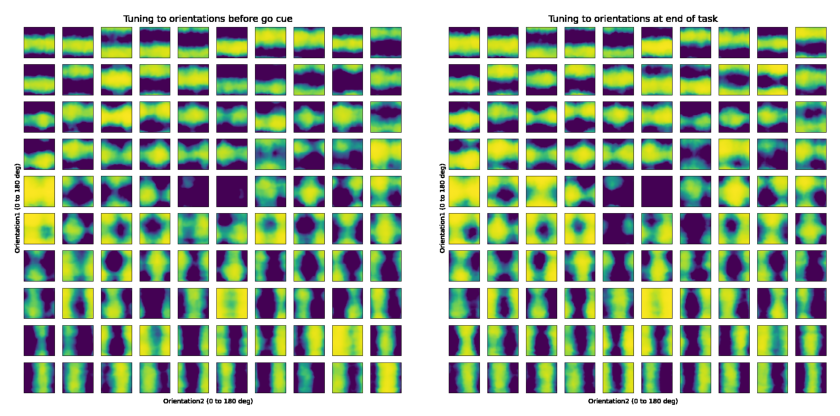

In [328]:
show_images_side_by_side((plt_to_image(get_tuning_heatmaps(total_time - 1 - hold_cue_for, "before go cue")),
                         plt_to_image(get_tuning_heatmaps(total_time - 1, "at end of task"))))
#get_tuning_heatmaps(total_time - 1 , "at end of task")

### Video of tunings over time

In [48]:
res = 9
_, _, soutput_reset = errors_when_reset_units_at_timestep(DT_indices[-1], list(range(total_time)), mean=False, res=res**2)
data_all_reset = torch.zeros((total_time, dim_recurrent, 180//res, 180//res))
for orientation1 in range(180//res):
    for orientation2 in range(180//res):
        o = soutput_reset[1][orientation1 * (180//res) + orientation2]
        data_all_reset[:, :, orientation1, orientation2] = o

tensor(False) tensor(False) tensor(False)


In [41]:
def get_title(timestep):
    if timestep >= hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2:
        return "cue2 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1+delay2:
        return "cue1 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1:
        return "delay2"
    if timestep >= hold_orientation_for+delay0+delay1:
        return "orientation2 presented"
    if timestep >= hold_orientation_for+delay0:
        return "delay1"
    if timestep >= delay0:
        return "orientation1 presented"
    return "delay0"

In [50]:
dirname = "figs10"

import pathlib
_path = pathlib.Path(f"data/{directory}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)

In [53]:
data_all_reset.shape

torch.Size([300, 100, 20, 20])

45(0.00%) 46(1.00%) 47(2.00%) 48(3.00%) 49(4.00%) 50(5.00%) 51(6.00%) 52(7.00%) 53(8.00%) 54(9.00%) 55(10.00%) 56(11.00%) 57(12.00%) 58(13.00%) 59(14.00%) 60(15.00%) 61(16.00%) 62(17.00%) 63(18.00%) 64(19.00%) 65(20.00%) 66(21.00%) 67(22.00%) 68(23.00%) 69(24.00%) 70(25.00%) 71(26.00%) 72(27.00%) 73(28.00%) 74(29.00%) 75(30.00%) 76(31.00%) 77(32.00%) 78(33.00%) 79(34.00%) 80(35.00%) 81(36.00%) 82(37.00%) 83(38.00%) 84(39.00%) 85(40.00%) 86(41.00%) 87(42.00%) 88(43.00%) 89(44.00%) 90(45.00%) 91(46.00%) 92(47.00%) 93(48.00%) 94(49.00%) 95(50.00%) 96(51.00%) 97(52.00%) 98(53.00%) 99(54.00%) 100(55.00%) 101(56.00%) 102(57.00%) 103(58.00%) 104(59.00%) 105(60.00%) 106(61.00%) 107(62.00%) 108(63.00%) 109(64.00%) 110(65.00%) 111(66.00%) 112(67.00%) 113(68.00%) 114(69.00%) 115(70.00%) 116(71.00%) 117(72.00%) 118(73.00%) 119(74.00%) 120(75.00%) 121(76.00%) 122(77.00%) 123(78.00%) 124(79.00%) 125(80.00%) 126(81.00%) 127(82.00%) 128(83.00%) 129(84.00%) 130(85.00%) 131(86.00%) 132(87.00%) 133(88.00

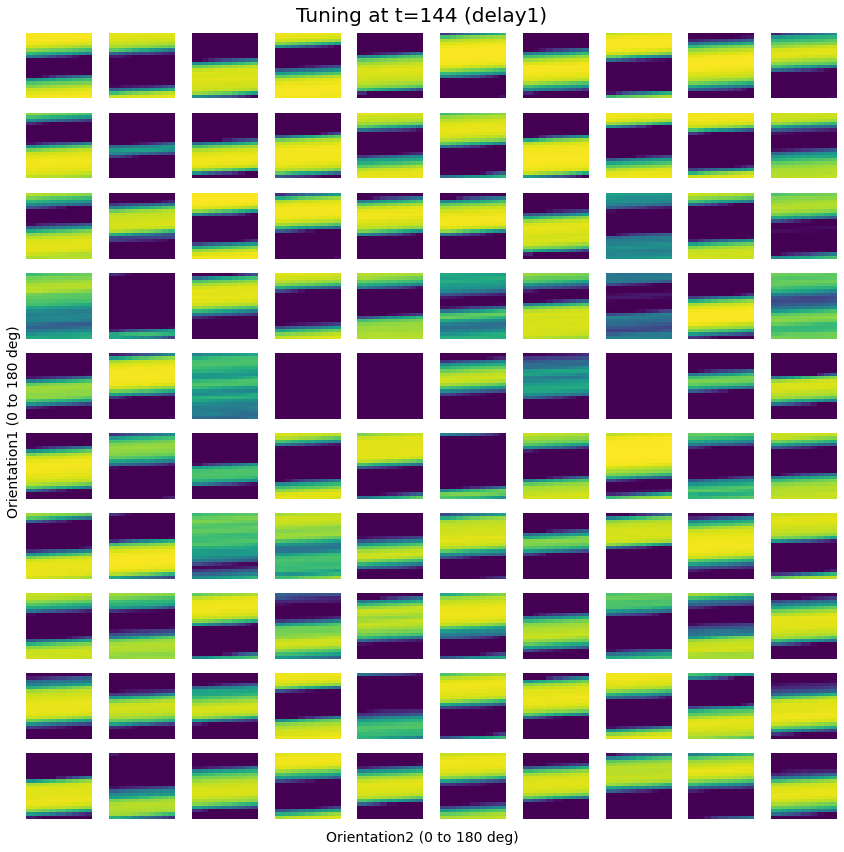

In [55]:
start_from = 45
go_to = 145
for t in range(start_from, go_to):
    plt.close('all')
    sqt = round(dim_recurrent ** 0.5)
    fig, ax = plt.subplots(nrows=sqt, ncols=sqt, figsize=(12, 12), facecolor='white')
    for i in range(dim_recurrent):
        a = ax[i // sqt][i % sqt]
        a.imshow(data_all_reset[t][tuning_indices[-1]][i].detach().numpy(), vmin=0, vmax=1)
        a.title.set_visible(False)
        a.axis('off')
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
    plt.tight_layout()
    st = fig.suptitle(f"Tuning at t={t:03} ({get_title(t)})", fontsize=20)
    #st.set_y(0.95)
    fig.supxlabel('Orientation2 (0 to 180 deg)', fontsize=14)
    fig.supylabel('Orientation1 (0 to 180 deg)', fontsize=14)
    fig.subplots_adjust(top=0.95, left=0.04, bottom=0.04)
    plt.savefig(f"data/{directory}/{dirname}/fig{t:03}.png")
    print(f"{t}({(t-start_from)/(go_to-start_from)*100:.2f}%)", end=" ")

In [28]:
os.system(f"ffmpeg -framerate 10 -pattern_type glob -i 'data/{directory}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p data/{directory}/{dirname}.mp4")

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

frame=   81 fps=0.0 q=-1.0 Lsize=     553kB time=00:00:07.80 bitrate= 581.0kbits/s speed=10.7x    
video:552kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.298867%
[libx264 @ 0x7f9072019a00] frame I:1     Avg QP:20.73  size: 81388
[libx264 @ 0x7f9072019a00] frame P:44    Avg QP:21.46  size: 10330
[libx264 @ 0x7f9072019a00] frame B:36    Avg QP:23.25  size:   784
[libx264 @ 0x7f9072019a00] consecutive B-frames: 33.3% 17.3% 14.8% 34.6%
[libx264 @ 0x7f9072019a00] mb I  I16..4: 17.5% 31.1% 51.4%
[libx264 @ 0x7f9072019a00] mb P  I16..4:  0.9%  0.8%  0.6%  P16..4: 20.5% 12.9%  9.6%  0.0%  0.0%    skip:54.9%
[libx264 @ 0x7f9072019a00] mb B  I16..4:  0.3%  0.2%  0.0%  B16..8: 14.5%  0.4%  0.1%  direct: 1.2%  skip:83.3%  L0:18.2% L1:78.6% BI: 3.1%
[libx264 @ 0x7f9072019a00] 8x8 transform intra:34.4% inter:64.8%
[libx264 @ 0x7f9072019a00] coded y,uvDC,uvAC intra: 41.4% 65.3% 60.5% inter: 9.3% 17.5% 9.7%
[libx264 @ 0x7f9072019a00] i16 v,h,dc,p: 56% 35%  8%  1%
[l

In [ ]:
plt.close('all')
sqt = round(dim_recurrent ** 0.5)
fig, ax = plt.subplots(nrows=sqt, ncols=sqt, figsize=(12, 12))
for i in range(dim_recurrent):
    a = ax[i // sqt][i % sqt]
    a.plot(range(180), torch.mean(data_o2[i], axis=0).detach().numpy(), "k")
    a.plot(range(180), torch.mean(data_o2[i], axis=1).detach().numpy(), "r")
    a.set_ylim(0, 1)
    a.title.set_visible(False)
    #a.axis('off')
    a.tick_params(left = True, labelleft = True , labelbottom = False, bottom = False)
plt.tight_layout()
st = fig.suptitle("Tuning to orientation before go cue", fontsize=20)
#st.set_y(0.95)
fig.subplots_adjust(top=0.95)

In [ ]:
plt.close('all')
sqt = round(dim_recurrent ** 0.5)
fig, ax = plt.subplots(nrows=sqt, ncols=sqt, figsize=(12, 12))
for i in range(dim_recurrent):
    a = ax[i // sqt][i % sqt]
    a.imshow(data_end[i].detach().numpy())
    a.title.set_visible(False)
    a.axis('off')
    a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()
st = fig.suptitle("Tuning to orientation at last point", fontsize=20)
#st.set_y(0.95)
fig.subplots_adjust(top=0.95)

In [ ]:
plt.close('all')
sqt = round(dim_recurrent ** 0.5)
fig, ax = plt.subplots(nrows=sqt, ncols=sqt, figsize=(12, 12))
for i in range(dim_recurrent):
    a = ax[i // sqt][i % sqt]
    a.imshow(data_c1[i].detach().numpy())
    a.title.set_visible(False)
    a.axis('off')
    a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()
st = fig.suptitle("Tuning to orientation at end of cue1", fontsize=20)
#st.set_y(0.95)
fig.subplots_adjust(top=0.95)

In [ ]:
n = 20
o = model(task._make_trial(n, n, delay0, delay1, delay2)[0].unsqueeze(0))[1][0].T

plt.figure()
plt.plot(range(1, o.shape[1]+1), o[1].detach().numpy(), 'k.', markersize=10, label=str(i))
plt.xlabel('timestep')
plt.ylabel('value')
plt.title(f'Projection')
plt.legend()
plt.xticks([0, delay0, hold_orientation_for+delay0, hold_orientation_for+delay1+delay0, hold_orientation_for*2+delay1+delay0, hold_orientation_for*2+delay1+delay2+delay0, hold_orientation_for*2+delay1+delay2+hold_cue_for+delay0, hold_orientation_for*2+delay1+delay2+hold_cue_for*2+delay0])
plt.show()

In [ ]:
o = model(task._make_trial(delay0=delay0, delay1=delay1, delay2=delay2)[0][0])[1][0].T

plt.figure()
for i in range(4):
    plt.plot(range(1, total_time+1), o[i].detach().numpy(), "krbgycm"[i]+'.', markersize=10, label=str(i))
plt.xlabel('timestep')
plt.ylabel('value')
plt.title(f'Projection')
plt.legend()
plt.xticks([0, hold_orientation_for, hold_orientation_for+delay1, hold_orientation_for*2+delay1, hold_orientation_for*2+delay1+delay2, hold_orientation_for*2+delay1+delay2+hold_cue_for, hold_orientation_for*2+delay1+delay2+hold_cue_for*2])
plt.show()